In [55]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand


In [56]:
# Likelihood ratios and decisions
f0 = lambda x: np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
f1 = lambda x: 0.5 * (np.exp(-(x+1)**2 / 2) + np.exp(-(x-1)**2 / 2)) / np.sqrt(2 * np.pi)


In [57]:

# Parameters
N = 10**6

# Part b: Generating data

def make_X0(r,c):
    return rand.normal(0, 1, (r, c))

def make_X1(r,c):
    x= np.zeros((r,c))
    for i in range(r):
        for j in range(c):
            if rand.randn()>=0:
                x[i][j]=rand.normal(loc=-1, scale = 1)
            else:
                x[i][j]=rand.normal(loc=+1, scale = 1)
    return x

X0 = make_X0(N,2)
X1 = make_X1(N,2)


In [58]:
#likelihood ratios and decisions

lr_X0 = (f1(X0[:, 0]) * f1(X0[:, 1])) / (f0(X0[:, 0]) * f0(X0[:, 1]))
lr_X1 = (f1(X1[:, 0]) * f1(X1[:, 1])) / (f0(X1[:, 0]) * f0(X1[:, 1]))

d_X1 = lr_X0>=1 #if true: decides X1 (false decision) / else: decides X0 (true decision)
d_X0 = lr_X1<1 #if true: decides X0 (false decision) / else: decides X1 (true decision)

# Error probabilities
error_x1 = np.mean(d_X1) #falses/N from X0
error_x0 = np.mean(d_X0) #falses/N from X1
bayes_error = 0.5 * (error_x0 + error_x1)

print("Optimal H_0 error probability", error_x0)
print("Optimal H_1 error probability", error_x1)
print("Optimal total error probability:", bayes_error)

Optimal H_0 error probability 0.422939
Optimal H_1 error probability 0.282951
Optimal total error probability: 0.352945


In [59]:

def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def diff_sigmoid(z):
    # np.clip(z, -500, 500)
    return sigmoid(z)/(1-sigmoid(z))


def relu(z):
    return np.maximum(z,0)


def diff_relu(z):
    return np.where(z>0, 1, 0)

def cross_entropy(z1, z2):
    # z1 = np.clip(z1, 1e-10, 1 - 1e-10)
    # z2 = np.clip(z2, 1e-10, 1 - 1e-10)
    return -np.log(1 - z1) - np.log(z2)


def diff_cross_entropy(z1, z2):
    # z1 = np.clip(z1, 1e-10, 1 - 1e-10)
    # z2 = np.clip(z2, 1e-10, 1 - 1e-10)
    return 1 / (1 - z1) - 1 / z2


def phi_cross_entropy(z):
    # z = np.clip(z, 1e-10, 1 - 1e-10)
    return -np.log(1 - z)

def psi_cross_entropy(z):
    # z = np.clip(z, 1e-10, 1 - 1e-10)
    return -np.log(z)


def diff_phi_cross_entropy(z):
    # z = np.clip(z, 1e-10, 1 - 1e-10)
    return 1 / (1 - z)

def diff_psi_cross_entropy(z):
    # z = np.clip(z, 1e-10, 1 - 1e-10)
    return -1 / z

def exponential(z1, z2):
    return np.exp(0.5*z1)+np.exp(-0.5*z2)
def diff_exponential(z1,z2):
    return 0.5*np.exp(0.5*z1) + 0.5*np.exp(-0.5*z2)

def phi_exponential(z):
    return np.exp(0.5*z)
def psi_exponential(z):
    return np.exp(-0.5*z)

def diff_phi_exponential(z):
    return 0.5*np.exp(0.5*z)
def diff_psi_exponential(z):
    return -0.5*np.exp(-0.5*z)


In [60]:
def weight(m,n):
    matrix = np.random.normal(loc=0, scale = np.sqrt(1/(m*n)), size=(m,n))
    return matrix


In [88]:
class SimpleNN:
    def __init__(self, input_size, hidden_size, output_size, method = "cross_entropy"):
        self.inp = input_size
        self.hid = hidden_size
        self.out = output_size
        self.method =method
        self.A1 = weight(hidden_size, input_size)
        self.b1 = np.zeros((hidden_size, 1))
        self.A2 = weight(output_size, hidden_size)
        self.b2 = np.zeros((output_size, 1))

    def forward(self, X):
        self.z0 = X
        self.W1 = np.dot(self.A1, self.z0) + self.b1
        self.z1 = relu(self.W1)
        self.W2 = np.dot(self.A2, self.z1) + self.b2
        
        if self.method == "cross_entropy":
            self.y = sigmoid(self.W2)
        else:
            self.y = self.W2
        return self.y



    def backward(self, fwd):
        y0,z00,z01,W01,W02 = fwd[0]
        y1,z10,z11,W11,W12 = fwd[1]

        # update Network Parameters and normalize (ADAM scheme)
        if self.method=="cross_entropy":
            u02 = diff_phi_cross_entropy(y0)
            v02 = u02 * diff_sigmoid(W02)

            u12 = diff_psi_cross_entropy(y1)
            v12 = u12 * diff_sigmoid(W12)
        
        else:   
            u02 = diff_phi_exponential(y0)
            v02 = u02       # f(x)=x, f'(x)=1  
            u12 = diff_psi_exponential(y1)
            v12 = u12 

        u01 = self.A2.T*v02
        v01 = u01 * diff_relu(W01)

        u11 = self.A2.T*v12
        v11 = u11 * diff_relu(W11)
        

        P2 = ((v02*np.hstack((z01.T, [[1]])))
             +(v12*np.hstack((z11.T, [[1]]))))**2
        P1 = ((v02*np.hstack((z00.T, [[1]])))
             +(v12*np.hstack((z10.T, [[1]]))))**2
                
        if self.train_ctr:
            P2 = (1-self.lamda)*self.P2_old+(self.lamda)*P2
            P1 = (1-self.lamda)*self.P1_old+(self.lamda)*P1

        self.P2_old = P2
        self.P1_old = P1
        
        AB2 = (np.hstack((self.A2, self.b2))-self.m*
               (v02*np.hstack((z01.T, [[1]]))+
                v12*np.hstack((z11.T, [[1]])))/
                np.sqrt(self.c+P2))
        
        self.A2 = AB2[0:1, :20]
        self.b2 = AB2[0:1, 20:21]
     
        AB1 = (np.hstack((self.A1, self.b1))-self.m*
               (v01*np.hstack((z00.T, [[1]]))+
                v11*np.hstack((z10.T, [[1]])))/
                np.sqrt(self.c+P1))
        
        self.A1 = AB1[0:20, 0:2]
        self.b1 = AB1[0:20, 2:3]

        return
    
    def train(self, X, epochs=1000, learning_rate=0.001, lamda = 0.01 , c = 1e-200):
        self.m = learning_rate
        self.lamda = lamda
        self.c =c
        
        epoch_cost = np.zeros(epochs)
        cost = np.zeros(epochs*200)
        best_cost = np.inf
        self.smooth_cost = np.zeros(epochs)
        self.train_ctr = 0
        self.mean_cost = 0

        x0=X[0]
        x1=X[1]

        AA1 = self.A1
        bb1 = self.b1
        AA2 = self.A2
        bb2 = self.b2

        
        for epoch in range(epochs):
            for i in range(x0.shape[0]):
                output0=self.forward(np.vstack(x0[i]))
                fwd0 = self.y, self.z0,self.z1, self.W1,self.W2
                output1=self.forward(np.vstack(x1[i]))
                fwd1 = self.y, self.z0,self.z1, self.W1,self.W2
                fwd = fwd0, fwd1
                if self.method=="cross_entropy":
                    current_cost = cross_entropy(output0,output1)
                else:
                    current_cost= exponential(output0,output1)
                cost[self.train_ctr] = current_cost
            # # if epoch>=20:
            # #     current_cost = np.mean(cost[self.train_ctr-19:self.train_ctr+1])
            #     if i%20==0 and i>0:
            #         current_cost = np.mean(cost[-20+i:i])
            #     if current_cost < best_cost:
            #         self.backward(fwd)
            #         best_cost = current_cost
            #     #   cost[i] = best_cost
                if self.train_ctr<20:
                    mean_cost = np.mean(cost[:self.train_ctr+1])
                    #print(mean_cost)
                else:
                    mean_cost = np.mean(cost[self.train_ctr-19:self.train_ctr+1])

                self.backward(fwd)
                if mean_cost<best_cost:
                    #print(best_cost)
                    AA1 = self.A1
                    bb1 = self.b1
                    AA2 = self.A2
                    bb2 = self.b2
                    best_cost = mean_cost
                    #print(best_cost)
                else:
                    self.A1 == AA1
                    self.b1 = bb1
                    self.A2 == AA2
                    self.b2 = bb2
                    cost[self.train_ctr] = best_cost
                self.train_ctr += 1              
            current_epoch_cost = np.mean(cost[epoch*200:epoch*200+200])


            epoch_cost[epoch] = current_epoch_cost
                    
        self.smooth_cost = epoch_cost

In [62]:
X0_train = make_X0(200,2)
X1_train = make_X1(200,2)
X0_test = X0
X1_test = X1


In [89]:
ce_NN = SimpleNN(2,20,1)
ce_NN.train((X0_train,X1_train), epochs = 500)



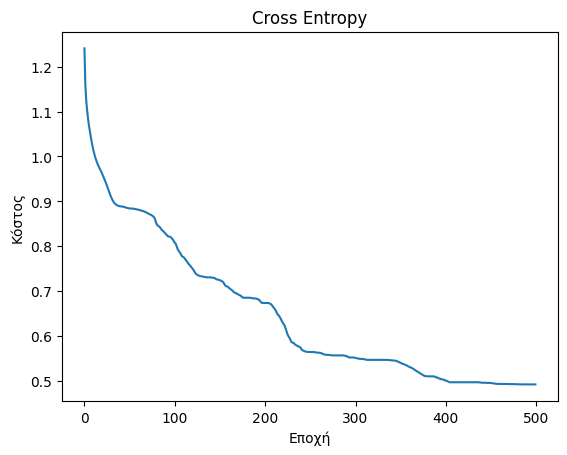

In [90]:
plt.plot(ce_NN.smooth_cost)
plt.xlabel('Εποχή')
plt.ylabel('Κόστος')
plt.title('Cross Entropy')
plt.show()

In [ ]:
exp_NN = SimpleNN(2,20,1, method = "exponential")
exp_NN.train((X0_train,X1_train), epochs = 500)

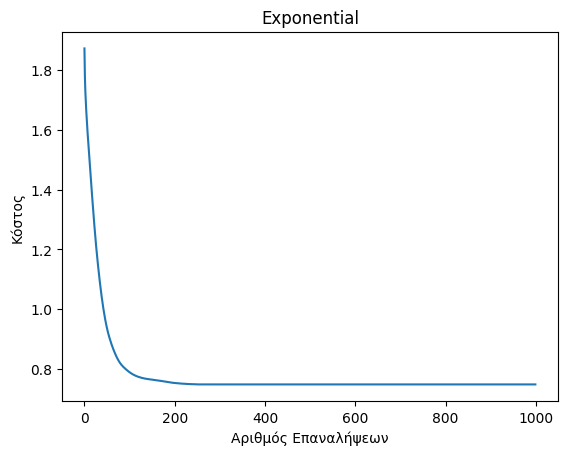

In [ ]:
plt.plot(exp_NN.smooth_cost)
plt.xlabel('Αριθμός Επαναλήψεων')
plt.ylabel('Κόστος')
plt.title('Exponential')
plt.show()


In [91]:
ce_d_x0=np.zeros(N)
ce_d_x1=np.zeros(N)
exp_d_x0=np.zeros(N)
exp_d_x1=np.zeros(N)
for i in range(N):
    x0 = np.vstack(X0_test[i])
    x1 = np.vstack(X1_test[i])
    
    ce_NN.forward(x0)
    # if wrong decision
    if (ce_NN.y)>=0.5:
        ce_d_x1[i]=1
    ce_NN.forward(x1)
    # if wrong decision
    if (ce_NN.y)<0.5:
        ce_d_x0[i]=1


    exp_NN.forward(x0)
    # if wrong decision
    if exp_NN.y>=0:
        exp_d_x1[i]=1

    exp_NN.forward(x1)
    # if wrong decision
    if exp_NN.y<0:
        exp_d_x0[i]=1






In [92]:
# Error probabilities
ce_error_x0 = np.mean(ce_d_x0) #falses/N from X0
ce_error_x1 = np.mean(ce_d_x1) #falses/N from X1
ce_error = 0.5 * (ce_error_x0 + ce_error_x1)
# Error probabilities
exp_error_x0 = np.mean(exp_d_x1) #falses/N from X0
exp_error_x1 = np.mean(exp_d_x0) #falses/N from X1
exp_error = 0.5 * (exp_error_x0 + exp_error_x1)

print("Optimal total error probability:", bayes_error)
print("Cross-Entropy total error probability:", ce_error)
print("Exponential total error probability:", exp_error)
print()

print("Bayes wrong H_0 probability:", error_x0)
print("Bayes wrong H_1 probability:", error_x1)

print()
print("cross-entropy wrong H_0 probability:", ce_error_x0)
print("cross-entropy wrong H_1 probability:", ce_error_x1)
print()

print("exponential wrong H_0 probability", exp_error_x1)
print("exponential wrong H_1 probability", exp_error_x0)




Optimal total error probability: 0.352945
Cross-Entropy total error probability: 0.435398
Exponential total error probability: 0.3588035

Bayes wrong H_0 probability: 0.422939
Bayes wrong H_1 probability: 0.282951

cross-entropy wrong H_0 probability: 0.220364
cross-entropy wrong H_1 probability: 0.650432

exponential wrong H_0 probability 0.375814
exponential wrong H_1 probability 0.341793
